In [1]:
import os
import sys
import time
import shutil
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow import keras
from tensorflow.keras import layers, models

import sklearn.preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

2024-09-14 12:05:01.528634: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 12:05:01.566050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:05:01.566093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:05:01.567942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 12:05:01.578978: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
    except RuntimeError as e:
        print(e)

2024-09-14 12:05:04.018570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 12:05:04.079820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 12:05:04.079954: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def get_dataset(directory, single_file=False, use_half=False, section=1, use_num_files=False, num_files=100):  
    if single_file:
        df = pd.read_csv(directory, index_col='timestamp')
        df.dropna(inplace=True)
        return df
    
    merged_df = pd.DataFrame()
    list_files = os.listdir(directory)
    print(len(list_files))
    if use_num_files:
        for i in range(num_files):
            df = pd.read_csv(os.path.join(directory, list_files[i]), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)

    if use_half:
        for i, files in enumerate(list_files):
            if section==1:
                if i > len(list_files) //2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
            if section==2:
                if i <= len(list_files) // 2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
    else:
        for files in list_files:
            df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # print(i)
    return merged_df

In [4]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables), dtype='float16')

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [5]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [6]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

In [7]:
def find_optimal_threshold(reconstruction_errors, y_true, num_steps=500):
    # Initialize variables
    best_f1 = 0
    best_upper_threshold = 0
    best_lower_threshold = 0
    best_y_pred = None
    
    # Calculate median, mean, and max of reconstruction errors
    q1 = np.percentile(reconstruction_errors, 25)
    q3 = np.percentile(reconstruction_errors, 75)
    max_error = np.max(reconstruction_errors)
    min_error = -1 * max_error
    
    # Define search ranges for upper and lower thresholds
    upper_search_range = np.linspace(q3, max_error, num=num_steps)
    lower_search_range = np.linspace(q1, min_error, num=num_steps)
    
    # Iterate over both thresholds in parallel
    for upper_threshold, lower_threshold in zip(upper_search_range, lower_search_range):
        if upper_threshold > lower_threshold:  # Ensure valid threshold combination
            # Get y_pred based on the current thresholds
            y_pred = np.where((reconstruction_errors > upper_threshold) | (reconstruction_errors < lower_threshold), 1, 0)
            
            # Calculate F1-score
            current_f1 = f1_score(y_true.astype(bool), y_pred.astype(bool))
            
            # Update if a better F1-score is found
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_upper_threshold = upper_threshold
                best_lower_threshold = lower_threshold
                best_y_pred = y_pred

    threshold_range = best_upper_threshold - best_lower_threshold
    # Iterate over possible starting points for the lower threshold
    for lower_threshold in np.linspace(min_error, max_error - threshold_range, num=num_steps):
        upper_threshold = lower_threshold + threshold_range

        if upper_threshold > max_error:  # Ensure valid upper threshold
            break

        # Generate predictions for the current threshold range
        y_pred = np.where((reconstruction_errors > upper_threshold) | (reconstruction_errors < lower_threshold), 1, 0)

        # Calculate F1-score
        current_f1 = f1_score(y_true.astype(bool), y_pred.astype(bool))

        # Update if a better F1-score is found
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_upper_threshold = upper_threshold
            best_lower_threshold = lower_threshold
            best_y_pred = y_pred

    return best_upper_threshold, best_lower_threshold, best_f1, best_y_pred


## Training

In [8]:
# dataset_dir = "../../datasets/3W/dataset_processed/splitted/0/train"

# list_files = os.listdir(dataset_dir)
# file_count = 100

# merged_df = pd.DataFrame()


# for i in range(len(list_files)):
#     # if i <= file_count:
#     #     continue
#     df = pd.read_csv(os.path.join(dataset_dir, list_files[i]), index_col='timestamp')
#     # if ['P-ANULAR','P-TPT','T-TPT','class'] == list(df.columns):
#     print(df.columns)
#     df.columns = ['C1', 'C2', 'C3', 'class']
#     merged_df = pd.concat([merged_df, df], ignore_index=True)
#     print(list_files[i])
#     if i >= file_count:
#         break

In [9]:
dataset_dir = "../../datasets/3W/dataset_processed/splitted/2/train"

list_files = os.listdir(dataset_dir)
file_count = 100

merged_df = pd.DataFrame()


for i in range(len(list_files)):
    # if i <= file_count:
    #     continue
    df = pd.read_csv(os.path.join(dataset_dir, list_files[i]), index_col='timestamp')
    # if ['P-ANULAR','P-TPT','T-TPT','class'] == list(df.columns):
    print(df.columns)
    df.columns = ['C1', 'C2', 'C3', 'class']
    merged_df = pd.concat([merged_df, df], ignore_index=True)
    print(list_files[i])
    # if i >= file_count * 2:
    #     break

Index(['P-ANULAR', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140726165720.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00012.csv
Index(['ESTADO-SDV-GL', 'ESTADO-SDV-P', 'T-TPT', 'class'], dtype='object')
WELL-00010_20171218180131.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140823230118.csv
Index(['P-ANULAR', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00013_20170329010229.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00004.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20141006150121.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140929210121.csv
Index(['P-ANULAR', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140720110102.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00015.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00014.csv
Index(['P-PDG', 'P-TPT', '

In [10]:
# merged_df = get_dataset('../../datasets/3W/dataset_processed/splitted/0/train')
merged_data_class = merged_df['class']

merged_data_np = merged_df.drop('class', axis=1).values

In [11]:
scaler = pickle.load(open('StandardScaler-3W-2.pkl', 'rb'))
# scaler = pickle.load(open('StandardScaler-3W-0.pkl', 'rb'))

merged_data_np_scaled = scaler.transform(merged_data_np)

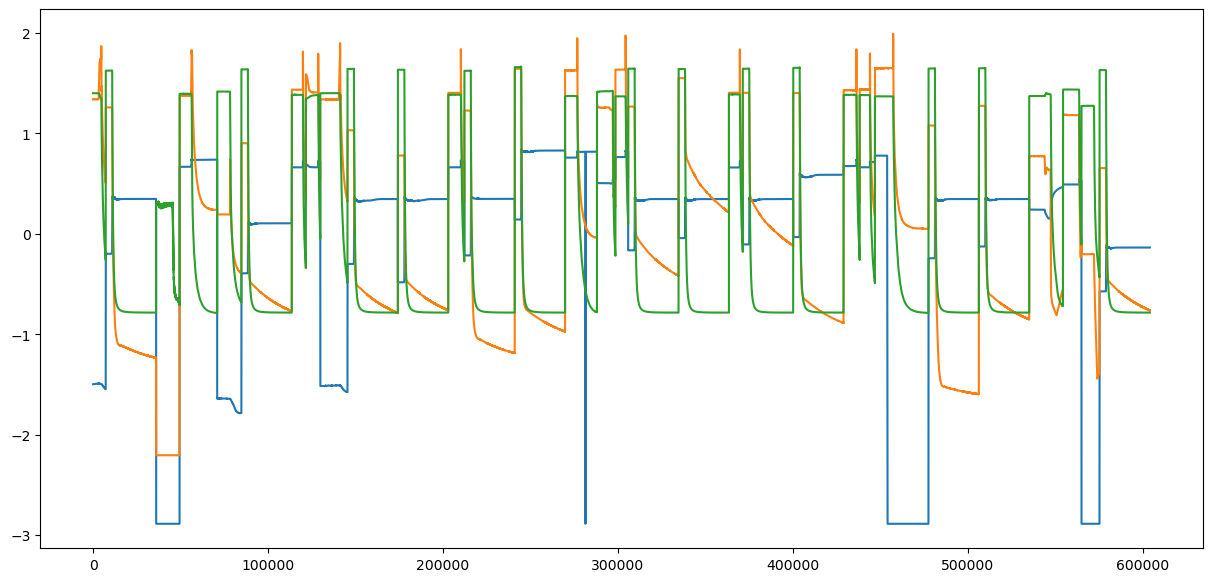

In [12]:
plt.figure(figsize=(15,7))
plt.plot(merged_data_np_scaled)
plt.show()

In [13]:
# scaler = sklearn.preprocessing.StandardScaler()
# scaler.fit(merged_data_np)

# merged_data_np_scaled = scaler.transform(merged_data_np)

# pickle.dump(scaler, open('StandardScaler-3W-2.pkl', 'wb'))

In [14]:
# merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)
merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)

In [15]:
merged_data_np_3d.dtype

dtype('float16')

In [16]:
merged_data_np_3d.shape

(604042, 10, 3)

In [ ]:
tf_dataset_path = "../../datasets/3W/dataset_processed/tf_data/LSTM-GAN/train/2"

dataset = tf.data.Dataset.from_tensor_slices(merged_data_np_3d)
dataset = dataset.batch(128)
tf.data.Dataset.save(dataset, tf_dataset_path)

### ==================================================

In [9]:
# To use available dataset
tf_dataset_path = "../../datasets/3W/dataset_processed/tf_data/LSTM-GAN/train/2"
dataset = tf.data.Dataset.load(tf_dataset_path)

2024-09-14 12:05:19.157701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 12:05:19.157904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 12:05:19.157945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 12:05:19.346564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 12:05:19.346617: I tensorflow/core/common_runtime/gpu/gpu

In [10]:
def build_encoder(input_shape):
    input_layer = layers.Input(shape=input_shape)
    encoder = layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = layers.LSTM(64, return_sequences=True)(encoder)
    encoder = layers.LSTM(32)(encoder)
    encoder = layers.Dense(24, activation='relu')(encoder)
    output_layer = layers.Dense(10, activation='relu')(encoder)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Encoder")    
    return model

def build_decoder(output_shape):
    input_layer = layers.Input(shape=(10,))
    decoder = layers.Dense(24, activation='relu')(input_layer)
    decoder = layers.Dense(24, activation='relu')(decoder)
    decoder = layers.RepeatVector(output_shape[0])(decoder)

    decoder = layers.LSTM(32, return_sequences=True)(decoder)
    decoder = layers.LSTM(64, return_sequences=True)(decoder)
    decoder = layers.LSTM(128, return_sequences=True)(decoder)

    output_layer = layers.TimeDistributed(layers.Dense(output_shape[1]))(decoder)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Decoder")
    
    return model

def build_discriminator(input_shape):
    input_layer = layers.Input(shape=input_shape)
    encoder = layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = layers.LSTM(64, return_sequences=True)(encoder)
    encoder = layers.LSTM(32)(encoder)
    encoder = layers.Dense(24, activation='relu')(encoder)
    encoder = layers.Dense(10, activation='relu')(encoder)
    output_layer = layers.Dense(1, activation='sigmoid')(encoder)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Discriminator")

    return model

In [11]:
class Generator(models.Model):
    def __init__(self, input_shape, output_shape):
        super(Generator, self).__init__()
        self.encoder = build_encoder(input_shape)
        self.decoder = build_decoder(output_shape)

    def call(self, x):
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x


In [13]:
# L1 norm for lx
def reconstruction_loss_lx(x, generated_x):
    return tf.reduce_mean(tf.abs(x - generated_x))

# L2 norm for lz
def reconstruction_loss_lz(z_enc1, z_enc2):
    return tf.reduce_mean(tf.square(z_enc1 - z_enc2))

# Adversarial loss for generator
def adversarial_loss(disc_output_gen):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_output_gen), disc_output_gen)

# Total Generator loss
def generator_loss(x, generated_x, z_enc1, z_enc2, disc_output_gen, w1, w2, w3):
    x = tf.cast(x, tf.float16)
    generated_x = tf.cast(generated_x, tf.float16)
    z_enc1 = tf.cast(z_enc1, tf.float16)
    z_enc2 = tf.cast(z_enc2, tf.float16)
    disc_output_gen = tf.cast(disc_output_gen, tf.float16)

    lx = reconstruction_loss_lx(x, generated_x)
    lz = reconstruction_loss_lz(z_enc1, z_enc2)
    ladv = adversarial_loss(disc_output_gen)
    return w1 * lx + w2 * lz + w3 * ladv

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [14]:
# Define the input shape
time_window = 10 
features = 3  
input_shape = (time_window, features)

# Instantiate models
generator = Generator(input_shape, input_shape)
discriminator = build_discriminator(input_shape)
encoder2 = build_encoder(input_shape)

# Define optimizers
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Example of compiling the discriminator
discriminator.compile(optimizer=disc_optimizer, loss='binary_crossentropy')


2024-09-14 12:05:35.374032: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [15]:
generator.encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
Total params: 130450 (509.57 KB)
Trainable params: 130450 (

In [16]:
generator.decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 24)            0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 10, 32)            7296      
                                                                 
 lstm_4 (LSTM)               (None, 10, 64)            24832     
                                                           

In [17]:
encoder2.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 128)           67584     
                                                                 
 lstm_10 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 24)                792       
                                                                 
 dense_9 (Dense)             (None, 10)                250       
                                                                 
Total params: 130450 (509.57 KB)
Trainable params: 130450 (

In [18]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 128)           67584     
                                                                 
 lstm_7 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 24)                792       
                                                                 
 dense_6 (Dense)             (None, 10)                250       
                                                                 
 dense_7 (Dense)             (None, 1)               

In [19]:
# # Example data (Replace with real dataset)
# X = np.random.randn(100, time_window, features)  # 1000 samples of time-series data
# X = np.float16(X)
# # Convert to TensorFlow Dataset
# batch_size = 32
# dataset = tf.data.Dataset.from_tensor_slices(X)
# dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

# Prefetch for performance optimization
data_loader = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [20]:
def generate_random_noise(batch_size, time_window, features):
    return tf.random.normal(shape=(batch_size, time_window, features))

In [22]:
import warnings
warnings.filterwarnings('ignore')

epochs = 10  # Example number of epochs
w1 = 0.2
w2 = 0.3
w3 = 0.5
# batch_size = 128

for epoch in range(epochs):
    gen_loss_total = 0
    disc_loss_total = 0
    num_batches = 0
    
    for batch in data_loader:
        batch_size = np.array(batch).shape[0]  
        # print("Generate random noise...")
        z = generate_random_noise(batch_size, time_window, features) 
        z = np.float16(z)
        num_batches += 1
        
        # Train discriminator
        with tf.GradientTape() as disc_tape:
            real_output = discriminator(np.array(batch))  # Discriminator evaluates real data
            generated_x = generator(z)          # Generator produces data from noise
            fake_output = discriminator(generated_x)  # Discriminator evaluates generated data
            disc_loss = discriminator_loss(real_output, fake_output)
        
        # print("Discriminator train...")
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        # Train generator
        with tf.GradientTape() as gen_tape:
            generated_x = generator(z)          # Generator produces data from noise
            fake_output_gen = discriminator(generated_x)  # Discriminator evaluates generated data
            
            # Since we're training the generator, we compare the generated data against real data
            z_enc1 = generator.encoder(np.array(batch))  # Encoder1 with real data
            z_enc2 = encoder2(generated_x)     # Encoder2 with generated data
            
            gen_loss = generator_loss(batch, generated_x, z_enc1, z_enc2, fake_output_gen, w1, w2, w3)
        
        # print("Generator train...")
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        gen_loss_total += gen_loss.numpy()
        disc_loss_total += disc_loss.numpy()

        if num_batches % 100 == 0:
            print(f'[{num_batches}]: \tloss_g: {gen_loss}, loss_d: {disc_loss}')
    
    avg_gen_loss = gen_loss_total / num_batches
    avg_disc_loss = disc_loss_total / num_batches
    
    # Log the losses
    print(f'Epoch {epoch+1}/{epochs}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}')
    # save each model
    generator.encoder.save("../../models/3W/LSTM-GAN/2/generator-encoder-v1.h5")
    generator.decoder.save("../../models/3W/LSTM-GAN/2/generator-decoder-v1.h5")
    encoder2.save("../../models/3W/LSTM-GAN/2/encoder2-v1.h5")
    discriminator.save("../../models/3W/LSTM-GAN/2/discriminator-v1.h5")


2024-09-14 12:08:22.944488: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-14 12:08:24.717520: I external/local_xla/xla/service/service.cc:168] XLA service 0x55f23086b840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-14 12:08:24.717571: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T500, Compute Capability 7.5
2024-09-14 12:08:24.770967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726290505.017655  234985 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[100]: 	loss_g: 0.654296875, loss_d: 1.4952092170715332
[200]: 	loss_g: 0.53271484375, loss_d: 0.9269245862960815
[300]: 	loss_g: 0.78125, loss_d: 0.6065987944602966
[400]: 	loss_g: 0.966796875, loss_d: 0.5558650493621826
[500]: 	loss_g: 0.8994140625, loss_d: 1.343730092048645
[600]: 	loss_g: 1.68359375, loss_d: 0.7516871690750122
[700]: 	loss_g: 0.9658203125, loss_d: 0.2334253340959549
[800]: 	loss_g: 1.49609375, loss_d: 0.2105514109134674
[900]: 	loss_g: 2.57421875, loss_d: 2.8747167587280273
[1000]: 	loss_g: 1.140625, loss_d: 1.663999080657959
[1100]: 	loss_g: 0.88720703125, loss_d: 1.2146755456924438
[1200]: 	loss_g: 0.9052734375, loss_d: 1.681247591972351
[1300]: 	loss_g: 0.63525390625, loss_d: 0.9838840961456299
[1400]: 	loss_g: 0.7607421875, loss_d: 1.3476519584655762
[1500]: 	loss_g: 0.94189453125, loss_d: 0.5332922339439392
[1600]: 	loss_g: 1.369140625, loss_d: 0.38934797048568726
[1700]: 	loss_g: 1.1123046875, loss_d: 2.1072802543640137
[1800]: 	loss_g: 1.0908203125, loss_d: 

In [23]:
generator.encoder.save("../../models/3W/LSTM-GAN/generator-encoder-v1.h5")
generator.decoder.save("../../models/3W/LSTM-GAN/generator-decoder-v1.h5")
encoder2.save("../../models/3W/LSTM-GAN/encoder2-v1.h5")
discriminator.save("../../models/3W/LSTM-GAN/discriminator-v1.h5")

In [24]:
ttt = [np.array(batch).shape for batch in data_loader]
print(len(ttt))

4720


In [17]:
# Sample dataset and training example
# train_data = merged_data_np_3d
# train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(32)

## Testing

In [25]:
dataset_dir = "../../datasets/3W/dataset_processed/splitted/2/test"

list_files = os.listdir(dataset_dir)
file_count = 1

merged_df_test = pd.DataFrame(columns=['C1','C2','C3','class'])

for i in range(file_count):
    df = pd.read_csv(os.path.join(dataset_dir, list_files[i]), index_col='timestamp')
    df.columns = ['C1','C2','C3','class']
    merged_df_test = pd.concat([merged_df_test, df], ignore_index=True)

In [26]:
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [27]:
scaler_test = pickle.load(open('StandardScaler-3W-0.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np_scaled, 10)

In [33]:
generator_encoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/generator-encoder-v1.h5")
generator_decoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/generator-decoder-v1.h5")

In [34]:
generator_encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
Total params: 130450 (509.57 KB)
Trainable params: 130450 (

In [35]:
generator_decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 24)            0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 10, 32)            7296      
                                                                 
 lstm_4 (LSTM)               (None, 10, 64)            24832     
                                                           

In [36]:
Z_test = generator_encoder(merged_data_test_np_3d)
pred_3d_np = generator_decoder(Z_test).numpy()

In [37]:
pred_2d = inverse_convert_time_window(pred_3d_np)
pred_2d_inv = scaler_test.inverse_transform(pred_2d)

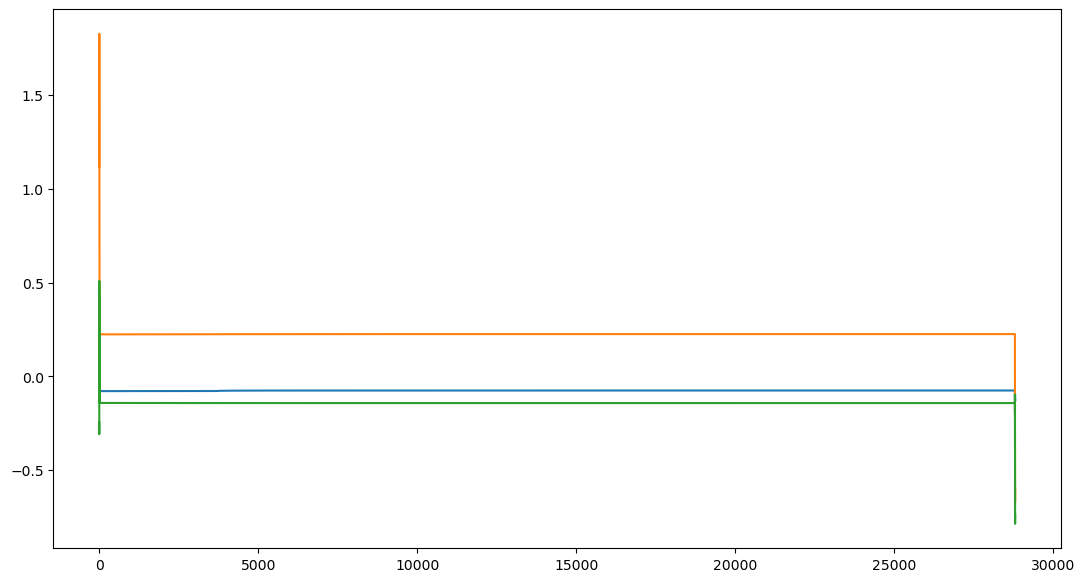

In [41]:
plt.figure(figsize=(13,7))
# plt.plot(merged_data_test_np_scaled)
plt.plot(pred_2d)
# plt.legend(['C1','C2','C3','C1-rec','C2-rec','C3-rec',])
plt.show()

In [45]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, pred_2d)

In [46]:
thres_up, thres_down, f1, y_pred = find_optimal_threshold(r_e, np.array(merged_data_test_class))
print(thres_up, thres_down, f1)

/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0 0 0


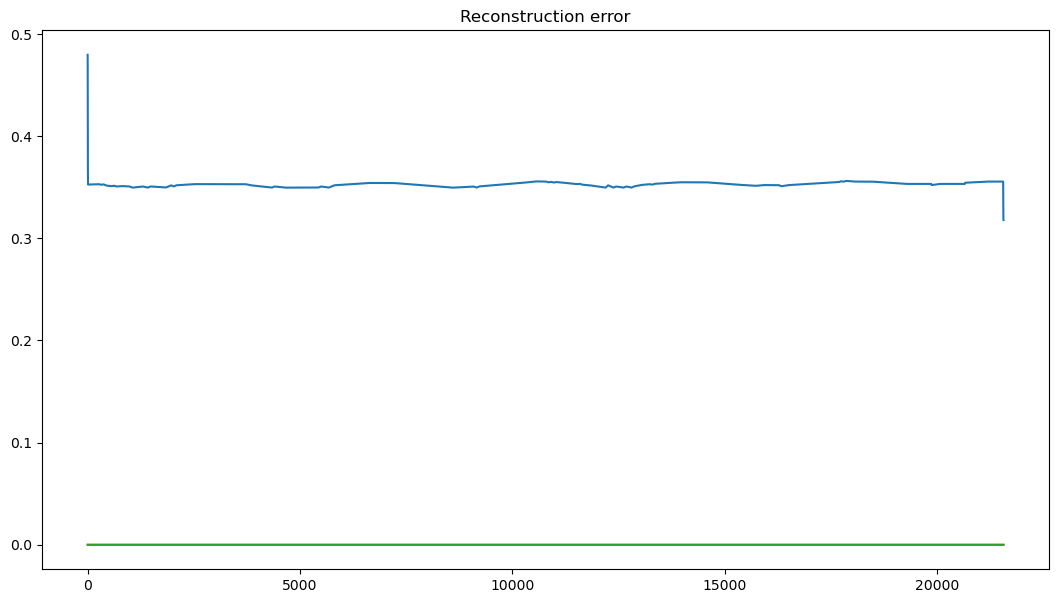

In [47]:
# iqr = np.percentile(r_e, 75) - np.percentile(r_e, 25)

plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(np.full(r_e.shape[0], thres))
plt.plot(np.full(r_e.shape[0], thres_down))
plt.plot(np.full(r_e.shape[0], thres_up))
plt.title("Reconstruction error")
# plt.legend(["reconstruction error", "threshold"])
plt.show()

In [18]:
# Train the model
# train(train_dataset, epochs=10)

c:\Users\farra\anaconda3\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 0.45279908180236816, Disc Loss: 1.5207252502441406
Epoch 2, Gen Loss: 0.4675253927707672, Disc Loss: 1.4082858562469482
Epoch 3, Gen Loss: 0.48224130272865295, Disc Loss: 1.3940682411193848
Epoch 4, Gen Loss: 5.453711032867432, Disc Loss: 0.0005041113472543657
Epoch 5, Gen Loss: 13.330048561096191, Disc Loss: 3.501121881299696e-08
Epoch 6, Gen Loss: 17.846107482910156, Disc Loss: 9.16796150107757e-09
Epoch 7, Gen Loss: 17.771203994750977, Disc Loss: 8.481889857137048e-09
Epoch 8, Gen Loss: 17.169925689697266, Disc Loss: 7.811036262239668e-09
Epoch 9, Gen Loss: 17.8572940826416, Disc Loss: 7.140829261231829e-09
Epoch 10, Gen Loss: 26.032379150390625, Disc Loss: 6.6587486635683035e-09


In [20]:
generator.save("generator_lstm_gan_10.h5")
discriminator.save("discriminator_lstm_gan_10.h5")

In [21]:
gener = keras.models.load_model("generator_lstm_gan_10.h5")

In [22]:
merged_df_test = get_dataset('dataset_processed/splitted/2/test')
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [27]:
scaler_test = pickle.load(open('StandardScaler.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np, 10)

In [28]:
test_data = merged_data_test_np_3d
fake_data = gener.predict(test_data)


3439/3439 [==============================] - 15s 4ms/step


In [31]:
fake_data_2d = inverse_convert_time_window(fake_data)

In [41]:
scalerrr = sklearn.preprocessing.StandardScaler()
fake_data_2d_scaled = scalerrr.fit_transform(fake_data_2d)

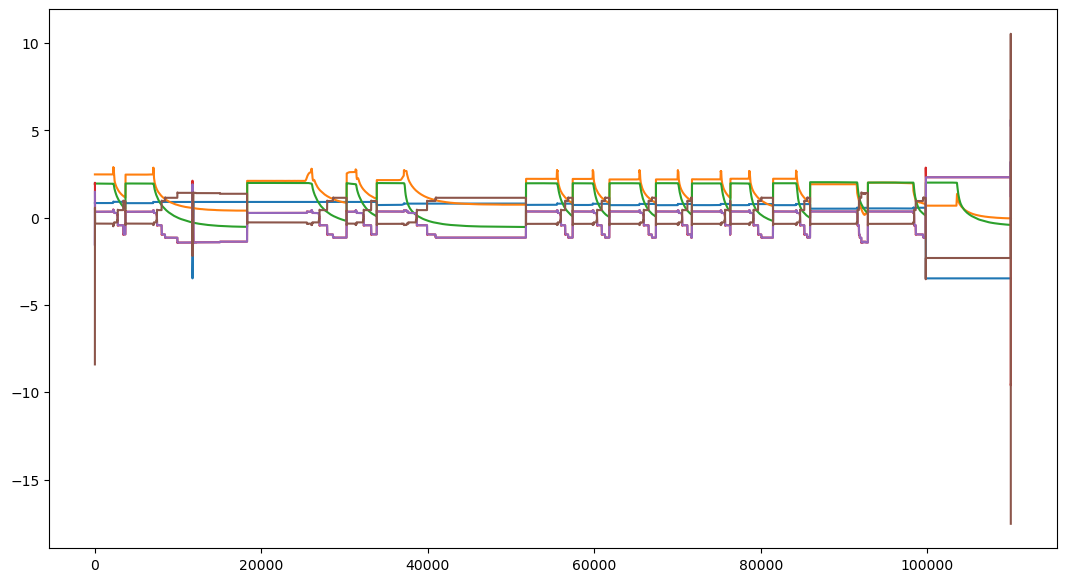

In [44]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np_scaled)
plt.plot(fake_data_2d_scaled)
plt.show()

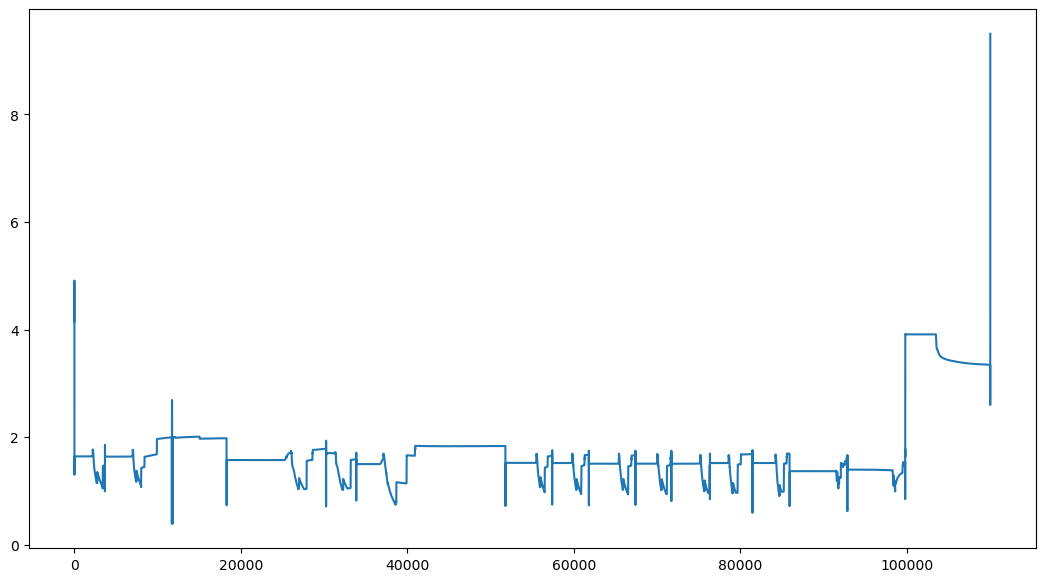

In [46]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, fake_data_2d_scaled)

plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(fake_data_2d_scaled)
plt.show()

In [28]:

# Latent space reconstruction loss
latent_real = generator(test_data)
latent_fake = generator(fake_data)

anomaly_score = np.mean(np.square(latent_real - latent_fake), axis=1)


In [ ]:

# Evaluate the model (replace `true_labels` with actual labels)
true_labels = np.random.randint(0, 4, size=1000)
evaluate_model(train_data, true_labels, thresholds=[0.2, 0.5, 0.7])